In [1]:
# Create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tobiaskarentiuskromanndahl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tobiaskarentiuskromanndahl/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Apply the nouns function to the transcripts to filter only on nouns
'''data_clean = pd.read_pickle('pickle/data_nouns.pkl')
data_nouns = pd.DataFrame(data_clean.content.apply(nouns))
data_nouns.to_pickle('pickle/data_nouns.pkl')'''

In [2]:
import pandas as pd
import pickle

data_nouns = pd.read_pickle('pickle/data_nouns.pkl')
data_df = pd.read_pickle('pickle/data_df.pkl')

data_nouns = data_nouns.join(data_df.date)

data_nouns["date"] = pd.to_datetime(data_nouns["date"]).dt.strftime("%W")
#data_nouns = data_nouns.groupby('date', as_index=False, sort=False).agg({'content': ' '.join})
data_nouns.head()

,content,date
0,cancer i cancer treatment today life i disbeli...,00
1,something link page commission work people gin...,00
2,cluster pneumonia city member family world hea...,01
3,airport mystery illness china credit update st...,01
4,finding outbreak pneumonia china people family...,01


In [13]:
# Import the necessary modules for LDA with gensim
from gensim import matutils, models
import scipy.sparse

In [21]:
ldas = dict()

for week in data_nouns.date.unique():

    # CountVectorizer will create a matrix of how many times each word has been mentioned.
    # The stop_words parameter will remove uninformative words such as 'him','her','the'.
    cv = CountVectorizer(stop_words='english')
    data_cv = cv.fit_transform(data_nouns[data_nouns.date == week].content)

    # Creating a new dataframe where columns is the newly found feature names.
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_dtm.index = data_nouns[data_nouns.date == week].index
    
    # One of the required inputs is a term-document matrix
    tdm = data_dtm.transpose()
    
    # We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
    sparse_counts = scipy.sparse.csr_matrix(tdm)
    corpus = matutils.Sparse2Corpus(sparse_counts)

    id2word = dict((v, k) for k, v in cv.vocabulary_.items())

    # LDA for num_topics
    ldas[week] = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, passes=10)
    print('\nWeek ', week)


Week  00

Week  01

Week  02

Week  03

Week  04

Week  05

Week  06

Week  07

Week  08

Week  09

Week  10

Week  11

Week  12

Week  13

Week  14

Week  15

Week  16

Week  17

Week  18


In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for week, lda in ldas.items():
    print(f'\nWeek: {week}\n')
    print(lda.print_topics())


Week: 00

[(0, '0.139*"ginger" + 0.035*"health" + 0.028*"research" + 0.028*"nausea" + 0.024*"effect" + 0.016*"body" + 0.016*"people" + 0.016*"inflammation" + 0.016*"medicine" + 0.016*"pain"'), (1, '0.005*"ginger" + 0.005*"health" + 0.005*"research" + 0.005*"nausea" + 0.005*"effect" + 0.004*"cancer" + 0.004*"supplement" + 0.004*"medicine" + 0.004*"body" + 0.004*"inflammation"'), (2, '0.006*"ginger" + 0.005*"health" + 0.005*"cancer" + 0.005*"nausea" + 0.005*"research" + 0.005*"effect" + 0.005*"time" + 0.005*"treatment" + 0.005*"supplement" + 0.005*"extract"'), (3, '0.005*"cancer" + 0.005*"time" + 0.005*"story" + 0.005*"ginger" + 0.004*"round" + 0.004*"treatment" + 0.004*"diagnosis" + 0.004*"day" + 0.004*"doctor" + 0.004*"life"'), (4, '0.059*"cancer" + 0.028*"time" + 0.020*"day" + 0.020*"life" + 0.016*"treatment" + 0.016*"recovery" + 0.016*"doctor" + 0.016*"diagnosis" + 0.016*"round" + 0.016*"story"')]

Week: 01

[(0, '0.003*"anxiety" + 0.003*"body" + 0.002*"people" + 0.002*"person" + 0.

In [ ]:
# Let's take a look at which topics each transcript contains
corpus_transformed = lda[corpus]
list(zip([a for [(a,b)] in corpus_transformed], data_dtm.index))

# Topic Area percentage over time

In [178]:
# Importing neccesary packages and the data from the pickle file.
import pandas as pd

data = pd.read_pickle("pickle/data_clean_r4.pkl")
data_with_more_labels = pd.read_pickle("pickle/data_df.pkl")
data_with_more_labels = data_with_more_labels.drop(columns="content")
data = data.join(data_with_more_labels)
data.head(3)

,content,title,date,domain,url,author,topic_area
0,so sorry to tell you that you have stage ovari...,My experience of surviving cancer twice,2020-01-03,medicalnewstoday,https://www.medicalnewstoday.com/articles/327373,Helen Ziatyk,healthcare
1,if you buy something through link on this page...,Ginger: Health benefits and dietary tips,2020-01-03,medicalnewstoday,https://www.medicalnewstoday.com/articles/2659...,Jenna Fletcher,healthcare
2,cluster of more than pneumonia in the central ...,China pneumonia outbreak may be caused by Sars...,2020-01-08,theguardian,https://www.theguardian.com/science/2020/jan/0...,Reuters,general


In [179]:
# Setting the data to group the date by weekly time with mean values.
import copy
data_weekly = copy.deepcopy(data)
data_weekly["date"] = pd.to_datetime(data["date"]).dt.strftime("%W")
data_weekly = data_weekly.groupby("date", as_index=False, sort=False).agg({'topic_area': ','.join})
data_weekly.head(5)

,date,topic_area
0,00,"healthcare,healthcare"
1,01,"general,science,general,healthcare,general,hea..."
2,02,"general,finance,finance,general,general,genera..."
3,03,"finance,general,finance,finance,finance,genera..."
4,04,"finance,general,business,business,business,fin..."


In [180]:
from collections import Counter
# Counts occurences and appends them to list_of_counts
list_of_counts = []
for e in data_weekly.topic_area:
    list_of_counts.append(dict(Counter(e.split(","))))

In [181]:
list_of_counts

[{'healthcare': 2},
 {'general': 3, 'science': 1, 'healthcare': 2},
 {'general': 6, 'finance': 6},
 {'finance': 160, 'general': 166, 'business': 19, 'science': 8, 'tech': 9},
 {'finance': 414, 'general': 292, 'business': 64, 'tech': 43, 'science': 14},
 {'general': 272,
  'business': 91,
  'tech': 36,
  'science': 10,
  'finance': 444,
  'healthcare': 1},
 {'general': 375,
  'finance': 541,
  'science': 15,
  'tech': 40,
  'business': 102,
  'automotive': 2},
 {'general': 238,
  'business': 102,
  'tech': 32,
  'finance': 474,
  'science': 10,
  'automotive': 3},
 {'finance': 871,
  'science': 16,
  'general': 637,
  'business': 182,
  'tech': 81,
  'automotive': 3,
  'healthcare': 1},
 {'finance': 1178,
  'general': 1043,
  'tech': 164,
  'automotive': 3,
  'science': 20,
  'business': 285,
  'healthcare': 1},
 {'finance': 2054,
  'general': 2064,
  'tech': 262,
  'business': 686,
  'science': 22,
  'automotive': 13,
  'healthcare': 1},
 {'general': 3332,
  'business': 1459,
  'tech':

In [182]:
# Calucalates the sum of values in each dict in list_of_counts
# and swaps each value with the percentage
for e in list_of_counts:
    sum_of_values= sum(e.values())
    for k,v in e.items():
        e[k] = v / sum_of_values

In [183]:
list_of_counts

[{'healthcare': 1.0},
 {'general': 0.5,
  'science': 0.16666666666666666,
  'healthcare': 0.3333333333333333},
 {'general': 0.5, 'finance': 0.5},
 {'finance': 0.4419889502762431,
  'general': 0.4585635359116022,
  'business': 0.052486187845303865,
  'science': 0.022099447513812154,
  'tech': 0.024861878453038673},
 {'finance': 0.5006045949214026,
  'general': 0.35308343409915355,
  'business': 0.0773881499395405,
  'tech': 0.05199516324062878,
  'science': 0.016928657799274487},
 {'general': 0.3185011709601874,
  'business': 0.10655737704918032,
  'tech': 0.04215456674473068,
  'science': 0.0117096018735363,
  'finance': 0.5199063231850117,
  'healthcare': 0.00117096018735363},
 {'general': 0.3488372093023256,
  'finance': 0.5032558139534884,
  'science': 0.013953488372093023,
  'tech': 0.037209302325581395,
  'business': 0.09488372093023256,
  'automotive': 0.0018604651162790699},
 {'general': 0.2770663562281723,
  'business': 0.11874272409778813,
  'tech': 0.037252619324796274,
  'fi

In [186]:
import numpy as np
import matplotlib.pyplot as plt

general, finance, science, business, tech, healthcare = [], [], [], [], [], []

# Prepare lists for plotting
for e in list_of_counts:
    if 'general' in e.keys():
        general.append(e['general'])
    else:
        general.append(0.0)
    if 'finance' in e.keys():
        finance.append(e['finance'])
    else:
        finance.append(0.0)
    if 'science' in e.keys():
        science.append(e['science'])
    else:
        science.append(0.0)
    if 'business' in e.keys():
        business.append(e['business'])
    else:
        business.append(0.0)
    if 'tech' in e.keys():
        tech.append(e['tech'])
    else:
        tech.append(0.0)
    if 'healthcare' in e.keys():
        healthcare.append(e['healthcare'])
    else:
        healthcare.append(0.0)

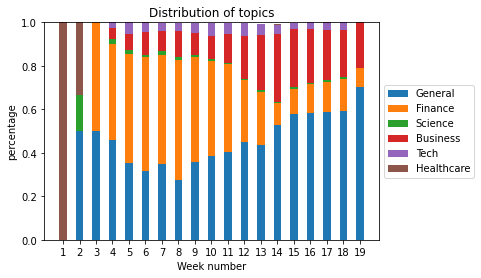

In [191]:
import numpy as np
import matplotlib.pyplot as plt

labels = [str(item) for item in range(1, 20)]
width = 0.45       # the width of the bars: can also be len(x) sequence

# sum of bars - to be used for bottom value
bars = np.add(general, finance).tolist()
bars1 = np.add(bars, science).tolist()
bars2 = np.add(bars1, business).tolist()
bars3 = np.add(bars2, tech).tolist()

fig, ax = plt.subplots()

ax.bar(labels, general, width, label='General')
ax.bar(labels, finance, width, bottom=general, label='Finance')
ax.bar(labels, science, width, bottom=bars, label='Science')
ax.bar(labels, business, width, bottom=bars1, label='Business')
ax.bar(labels, tech, width, bottom=bars2, label='Tech')
ax.bar(labels, healthcare, width, bottom=bars3, label='Healthcare')


ax.set_ylabel('percentage')
ax.set_xlabel('Week number')
ax.set_title('Distribution of topics')
# Places the legend at the bottom, below the plot
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.06),
#          fancybox=True, shadow=True, ncol=6)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()